1. 自注意力
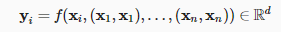
2. 位置编码
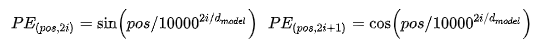
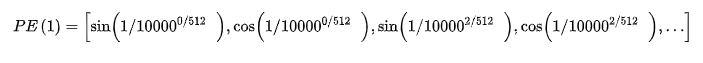

* 相对位置信息：
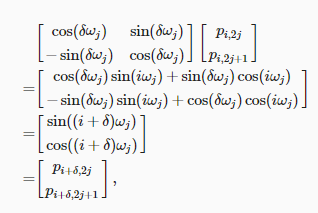

In [2]:
import math
import torch
from torch import nn
import dltools

In [3]:
num_hiddens, num_heads = 100, 5
attention = dltools.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.2)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [5]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
# 不带位置信息的自注意力
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [6]:
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        # 创建一个存放位置编码的tensor
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/ num_hiddens)
        # 取出所有的偶数列, 进行赋值
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [7]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros(1, num_steps, encoding_dim))
P = pos_encoding.P[:, :X.shape[1], :]
X.shape, P.shape

(torch.Size([1, 60, 32]), torch.Size([1, 60, 32]))

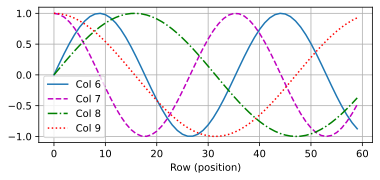

In [8]:
dltools.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)', figsize=(6, 2.5), legend=['Col %d' % d for d in torch.arange(6, 10)])